In [1]:
%matplotlib inline

import os
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pyspark
import pyspark.sql.functions as sparkfunc

matplotlib.rcParams['figure.dpi'] = 120

from dustmaps.sfd import SFDQuery

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config('spark.master', "local[8]") \
                            .config('spark.memory.offHeap.enabled', 'true') \
                            .config('spark.memory.offHeap.size', '16G') \
                            .config('spark.driver.memory', '16G') \
                            .config("spark.sql.execution.arrow.enabled", "true").getOrCreate()

In [3]:
gaia_ = spark.read.load("/epyc/data/gaia_dr2_1am_dup/")
gaia = gaia_.drop("hpix12").withColumn("hpix12",
                        sparkfunc.floor(gaia_['source_id']/34359738368))

In [22]:
%%time

sfd_order = 9
sfd = SFDQuery()
npix = hp.nside2npix(hp.order2nside(sfd_order))

angle_theta, angle_phi = hp.pix2ang(hp.order2nside(sfd_order), np.arange(npix), nest=True)

reddening = sfd.query_equ(np.rad2deg(angle_phi), 90.0 - np.rad2deg(angle_theta))

EBV_map_hpix12 = hp.ud_grade(reddening, hp.order2nside(12), order_in='NEST')
pandas_df = pd.DataFrame({"hpix12": np.arange(len(EBV_map_hpix12)),
                                             "EBV": EBV_map_hpix12})

reddening_df = spark.createDataFrame(pandas_df)

CPU times: user 14.5 s, sys: 36.7 s, total: 51.2 s
Wall time: 38.3 s


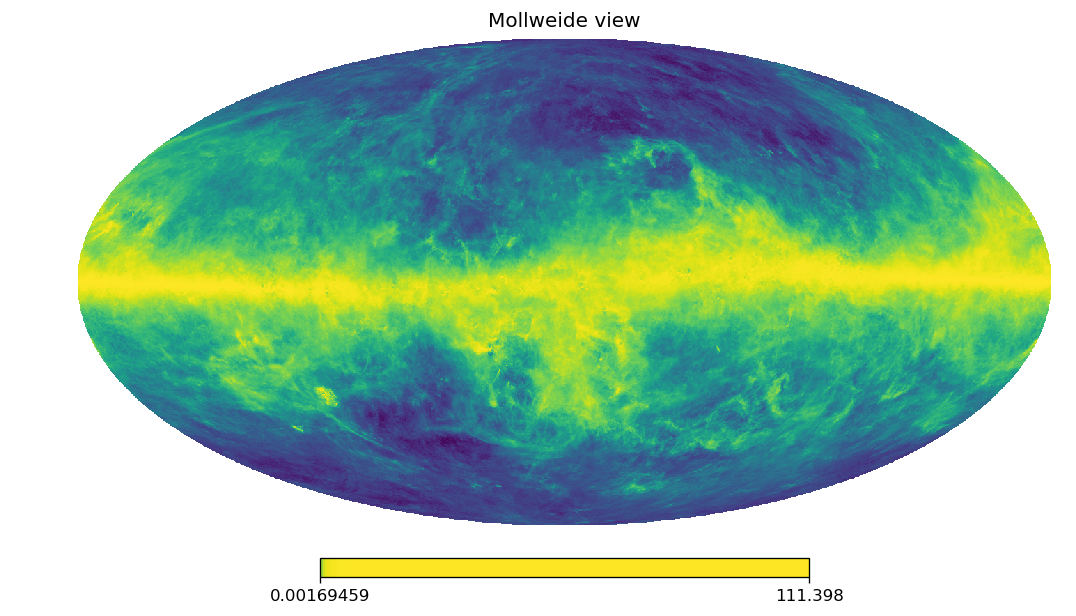

In [23]:
matplotlib.rcParams['figure.dpi'] = 120

hp.mollview(EBV_map_hpix12, rot=(266.4 - 180, 28.94, -57),
            xsize=1400,
            nest=True, norm='hist')

In [24]:
%%time
gaia_w_EBV = gaia.join(reddening_df, on="hpix12")

CPU times: user 1.89 ms, sys: 5.43 ms, total: 7.32 ms
Wall time: 39.1 ms


In [25]:
%%time
gaia_g0 = gaia_w_EBV.withColumn("phot_g0", gaia_w_EBV['phot_g_mean_mag'] - 3.1*gaia_w_EBV['EBV']).\
                      withColumn("bp_rp_0", gaia_w_EBV['bp_rp'] - 1.2919*gaia_w_EBV['EBV'])

#
# .cache() will make this horribly horribly slow!!
#
#gaia_g0.cache()
#gaia_g0.count()

CPU times: user 3.06 ms, sys: 3.72 ms, total: 6.78 ms
Wall time: 140 ms


In [7]:
from gaia_tools import healpix_hist, bin_column


In [50]:
%%time
dereddened_density2 = healpix_hist(gaia_g0. \
                                  where((gaia_g0['dup'] == 0) &
                                        (gaia_g0['bp_rp_0'] > 0.5) & (gaia_g0['bp_rp_0'] < 0.75) &
                                        (gaia_g0['phot_g0'] > 19) & (gaia_g0['phot_g0'] <= 20.5) &
                                        (gaia_g0['parallax'] < 0.2)),
                                   NSIDE=512, agg={"hpix__": "count"})

CPU times: user 121 ms, sys: 127 ms, total: 248 ms
Wall time: 4min 7s


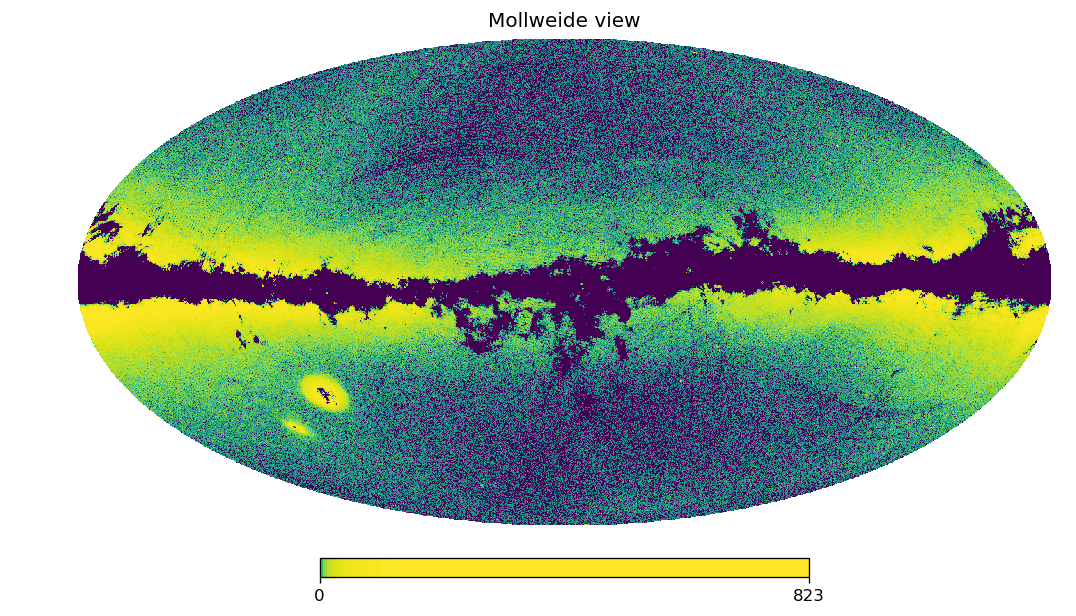

In [51]:
matplotlib.rcParams['figure.dpi'] = 120

hp.mollview(dereddened_density2, rot=(266.4 - 180, 28.94, -57),
            xsize=1400,
            nest=True, norm='hist')

In [43]:
from astropy.io import ascii
f_isochrone = ascii.read("dotter_isochrone.dat", header_start=8)

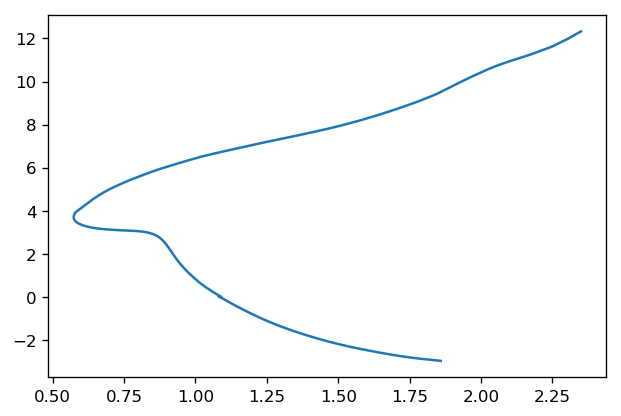

In [45]:
bp_rp = f_isochrone['Gaia_BP'] - f_isochrone['Gaia_RP']
plt.plot(bp_rp, f_isochrone['Gaia_G'])

Transformation to Galactic PM
----------------------------

Following https://arxiv.org/pdf/1306.2945.pdf

In [64]:
def spark_mu_l(alpha, delta, mu_ra, mu_dec):
    from pyspark.sql.functions import sin, cos
    alpha_g =  192.85948 * pi/180.0
    delta_g = 27.12825 * pi/180.0
    C1 = np.sin(delta_g) * cos(delta) - np.cos(delta_g) * sin(delta) * cos(alpha - alpha_g)
    C2 = np.cos(delta_g)* sin(alpha - alpha_g)
    cosb = sqrt(C1**2 + C2**2)    
    return (mu_ra * C1 + mu_dec * C2)/cosb

def spark_mu_b(alpha, delta, mu_ra, mu_dec):
    from pyspark.sql.functions import sin, cos, sqrt
    alpha_g =  192.85948 * pi/180.0
    delta_g = 27.12825 * pi/180.0
    C1 = np.sin(delta_g) * cos(delta) - np.cos(delta_g) * sin(delta) * cos(alpha - alpha_g)
    C2 = np.cos(delta_g)* sin(alpha - alpha_g)
    cosb = sqrt(C1**2 + C2**2)
    return (mu_ra * -C2 + mu_dec * C1)/cosb

In [65]:
from numpy import pi

gaia_g0_mulb = gaia_g0.withColumn("mu_l", spark_mu_l(gaia_g0['ra']*pi/180.0, gaia_g0['dec']*pi/180.0,
                                                     gaia_g0['pmra'], gaia_g0['pmdec'])) \
                      .withColumn("mu_b", spark_mu_b(gaia_g0['ra']*pi/180.0, gaia_g0['dec']*pi/180.0,
                                                     gaia_g0['pmra'], gaia_g0['pmdec']))

In [111]:
def sparkhist_2d(data1, data2, start1, end1, n1, start2, end2, n2):
    from pyspark.sql.functions import floor
    from pyspark.sql.types import IntegerType

    size1 = (end1 - start1)/n1
    size2 = (end2 - start2)/n2
    filter = ((data1 >= start1) & (data1 < end1) & (data2 >= start2) & (data2 < end2)).astype(IntegerType())
    return filter * (floor((data1 - start1)/size1) + n1 * floor((data2 - start2)/size2))

In [124]:
%%time

tmp_table = gaia_g0_mulb.withColumn("histbin", sparkhist_2d(gaia_g0_mulb['mu_l'], gaia_g0_mulb['mu_b'],
                                                                          -10, 10, 40, -10, 10, 40)) \
                          .where((gaia_g0_mulb['dup'] == 0) &
                                        (gaia_g0_mulb['bp_rp_0'] > 0.5) & (gaia_g0_mulb['bp_rp_0'] < 0.75) &
                                        (gaia_g0_mulb['phot_g0'] > 19) & (gaia_g0_mulb['phot_g0'] <= 20.5) &
                                        (gaia_g0_mulb['parallax'] < 0.2) &
                                        (gaia_g0_mulb['b'] > 10) & (gaia_g0_mulb['b'] < 45) &
                                        (gaia_g0_mulb['l'] > 150) & (gaia_g0_mulb['l'] < 220))
_mu_lb_hist = tmp_table.groupby(tmp_table["histbin"]).agg({"histbin": "count"}).toPandas()


CPU times: user 56.3 ms, sys: 31.2 ms, total: 87.5 ms
Wall time: 2min 3s


In [125]:
mu_lb_one_d = np.zeros(40*40)
mu_lb_one_d[_mu_lb_hist['histbin'].values] = _mu_lb_hist['count(histbin)'].values
mu_lb_hist = mu_lb_one_d.reshape(40,40)

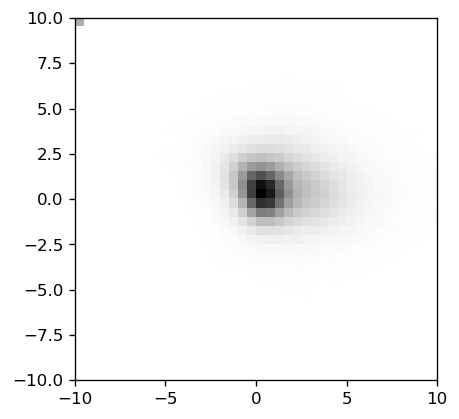

In [126]:
plt.imshow(mu_lb_hist, extent=(-10, 10, -10, 10), cmap='gray_r')